In [25]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.spatial.transform import Rotation as R
from scipy.sparse.linalg import eigs
from mpl_toolkits.mplot3d import axes3d
from scipy.sparse import dok_matrix
import sys
#import time
%matplotlib notebook

In [61]:
def rotation(coords, deg):
    x = len(coords[0])
    vectors = np.array([coords[0], coords[1], [0]*x]).T
    r = R.from_rotvec([0, 0, deg])
    a = r.apply(vectors)
    a = a[1:]
    a = a.T[0:-1]
    return a

def fractalGenerator(L, l):
    if l == 0:
        a = np.array([[0,L], [0,0]])
        return a
    
    segment = fractalGenerator(L/4, l-1)
    x = len(segment[0])-1
    corners = copy.copy(segment)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, 0), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, -1*np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, -1*np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, 0), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, 0), axis = 1)
    return corners

def fractalCorners(L, l):
    segment = fractalGenerator(L, l)
    x = len(segment[0])-1
    corners = copy.copy(segment)
    corners = corners.T[1:].T
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, -1*np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, -2*np.pi/2), axis = 1)
    corners = np.append(corners, [[corners[0][-1]]*x, [corners[1][-1]]*x] + rotation(segment, -3*np.pi/2), axis = 1)
    return np.round(corners, 12)

def makeGrid(L, l, N):
    corners = fractalCorners(L, l)
    x2, x1 = np.max(corners[0]), np.amin(corners[0])
    y2, y1 = np.max(corners[1]), np.amin(corners[1])
    Nx = N*(x2-x1)/((0.25)**l)+1
    Ny = N*(y2-y1)/((0.25)**l)+1
    dx, dy = (x2 - x1)/Nx, (y2 - y1)/Ny
    x = np.linspace(x1- 0.5*dx, x2 + 0.5*dx, int(Nx)+1)
    y = np.linspace(y1 - 0.5*dy, y2 + 0.5*dy, int(Ny)+1)
#     x = np.linspace(x1, x2, int(Nx))
#     y = np.linspace(y1, y2, int(Ny))
    X, Y = np.meshgrid(x, y)
    grid = np.array([X.flatten(),Y.flatten()])
    return grid, corners, x, y

def globalVariables(points):
    corners = points.T
    testx = copy.copy(corners)
    testy = copy.copy(corners.T)
    testy = np.flip(testx, axis = 1)
    testx = testx[np.lexsort(testx.T[::-1])].T
    testy = testy[np.lexsort(testy.T[::-1])].T
    return corners, testx, testy

def getIndex(arr, x, y):
    c1 = np.where(arr[0]==x)
    c2 = np.where(arr[1]==y)
    return np.intersect1d(c1, c2)

def determinePoint(x, y, testx, testy, corners):
    a, b = np.searchsorted(testx[0], x, side = 'left'), np.searchsorted(testx[0], x, side = 'right')
    c, d = np.searchsorted(testy[0], y, side = 'left'), np.searchsorted(testy[0], y, side = 'right')
    if a == b and c == d: #point lies off Koch grid lines
        a1 = np.searchsorted(testx[0], testx.T[a-1][0], side = 'left')
        if b >= len(testx[0]):
            return -1
        b1 = np.searchsorted(testx[0], testx.T[b][0], side = 'right')
        colL, colR = testx.T[a1:b], testx.T[b:b1]
        colR = np.flip(colR, axis = 1)
        colL = np.flip(colL, axis = 1)
        colL = colL[np.lexsort(colL.T[::-1])].T
        colR = colR[np.lexsort(colR.T[::-1])].T
        L = np.searchsorted(colL[0], y)
        R = np.searchsorted(colR[0], y)
        if L >= len(colL[0]) or R >= len(colR[0]) or L == 0 or R == 0: #is point within 4 Koch points?
            return -1 #no
        LT = getIndex(corners.T, colL.T[L][1], colL.T[L][0])
        LB = getIndex(corners.T, colL.T[L-1][1], colL.T[L-1][0])
        RT = getIndex(corners.T, colR.T[R][1], colR.T[R][0])
        RB = getIndex(corners.T, colR.T[R-1][1], colR.T[R-1][0])
        if LT < RT < RB < LB or RT < RB < LB < LT or RB < LB < LT < RT or LB < LT < RT < RB: #is point inside drum?
            return 1 #yes
        else: #has to be outside of drum
            return -1
    elif a == b: #does the point lie on a horisontal Koch points line? 
        c1 = np.searchsorted(testy[0], testy.T[c][0], side = 'left')
        row = testy.T[c1:d]
        row = np.flip(row, axis = 1)
        row = row[np.lexsort(row.T[::-1])].T
        I = np.searchsorted(row[0], x)
        if I >= len(row[0]) or I == 0:
            return -1 #boundary condition
        diff = np.abs(getIndex(corners.T, row.T[I][0], row.T[I][1]) - getIndex(corners.T, row.T[I-1][0], row.T[I-1][1]))
        if diff == 1 or diff == len(corners)-1:
            return 0 #point lies on the drum edge
        else:
            xR = row[0][I]
            xL = row[0][I-1]
            a1 = np.searchsorted(testx[0], xL, side = 'left')
            b1 = np.searchsorted(testx[0], xR, side = 'right')
            colL, colR = testx.T[a1:b], testx.T[b:b1]
            colR = np.flip(colR, axis = 1)
            colL = np.flip(colL, axis = 1)
            colL = colL[np.lexsort(colL.T[::-1])].T
            colR = colR[np.lexsort(colR.T[::-1])].T
            L = np.searchsorted(colL[0], y)
            R = np.searchsorted(colR[0], y)
            if L == 0 or L >= len(colL[0])-1 or R == 0 or R >= len(colR[0])-1: #is the point within 6 Koch points?
                return -1 #no
            LT = getIndex(corners.T, colL.T[L+1][1], colL.T[L+1][0])
            LB = getIndex(corners.T, colL.T[L-1][1], colL.T[L-1][0])
            RT = getIndex(corners.T, colR.T[R+1][1], colR.T[R+1][0])
            RB = getIndex(corners.T, colR.T[R-1][1], colR.T[R-1][0])
            if LT < RT < RB < LB or RT < RB < LB < LT or RB < LB < LT < RT or LB < LT < RT < RB: 
                return 1 #point is inside drum
            else:
                return -1 #point lies outside
    elif c == d: #does the point lie on a vertical Koch points line?
        a1 = np.searchsorted(testx[0], testx.T[a][0], side = 'left')
        col = testx.T[a1:b]
        col = np.flip(col, axis = 1)
        col = col[np.lexsort(col.T[::-1])].T
        I = np.searchsorted(col[0], y)
        if I >= len(col[0]) or I == 0:
            return -1 #boundary condition
        diff = np.abs(getIndex(corners.T, col.T[I][1], col.T[I][0]) - getIndex(corners.T, col.T[I-1][1], col.T[I-1][0]))
        if diff == 1 or diff == len(corners)-1:
            return 0 #point lies on the drum edge
        else:
            yT = col[0][I]
            yB = col[0][I-1]
            c1 = np.searchsorted(testy[0], yB, side = 'left')
            d1 = np.searchsorted(testy[0], yT, side = 'right')
            rowB, rowT = testy.T[c1:d], testy.T[d:d1]
            rowT = np.flip(rowT, axis = 1)
            rowB = np.flip(rowB, axis = 1)
            rowB = rowB[np.lexsort(rowB.T[::-1])].T
            rowT = rowT[np.lexsort(rowT.T[::-1])].T
            B = np.searchsorted(rowB[0], x)
            T = np.searchsorted(rowT[0], x)
            if B == 0 or B >= len(rowB[0])-1 or T == 0 or T >= len(rowT[0])-1: #is the point within 6 Koch points?
                return -1 #no
            else:
                LT = getIndex(corners.T, rowT.T[T-1][0], rowT.T[T-1][1])
                LB = getIndex(corners.T, rowB.T[B-1][0], rowB.T[B-1][1])
                RT = getIndex(corners.T, rowT.T[T+1][0], rowT.T[T+1][1])
                RB = getIndex(corners.T, rowB.T[B+1][0], rowB.T[B+1][1])
                if LT < RT < RB < LB or RT < RB < LB < LT or RB < LB < LT < RT or LB < LT < RT < RB:
                    return 1 #point is inside drum
                else:
                    return -1 #point is outside
    else: #point is on cross section between a horisontal line of Koch points and a vertical line of Koch points
        if len(getIndex(corners.T, x, y)): 
            return 0 #point lies on top of a Koch point
        else:
            c1 = np.searchsorted(testy[0], testy.T[c][0], side = 'left')
            if d >= len(testy[0]):
                return -1 #boundary condition
            row = testy.T[c1:d]
            row = np.flip(row, axis = 1)
            row = row[np.lexsort(row.T[::-1])].T
            R = np.searchsorted(row[0], x)
            a1 = np.searchsorted(testx[0], testx.T[a][0], side = 'left')
            if b >= len(testx[0]):
                return -1 #boundary condition
            b1 = np.searchsorted(testx[0], testx.T[b][0], side = 'right')
            col = testx.T[a1:b]
            col = np.flip(col, axis = 1)
            col = col[np.lexsort(col.T[::-1])].T
            C = np.searchsorted(col[0], y)
            if C == 0 or C >= len(col[0]) or R == 0 or R >= len(row[0]):
                return -1 #boundary condition
            L = getIndex(corners.T, row.T[R-1][0], row.T[R-1][1])
            R = getIndex(corners.T, row.T[R][0], row.T[R][1])
            T = getIndex(corners.T, col.T[C][1], col.T[C][0])
            B = getIndex(corners.T, col.T[C-1][1], col.T[C-1][0])
            if T < R < B < L or R < B < L < T or B < L < T < R or L < T < R < B: #point lies inside drum
                return 1
            else:
                return -1 #point lies outside drum
            
def makeStates(points, xlist, ylist):
    corners, testx, testy = globalVariables(points)
    Nx, Ny = len(xlist), len(ylist)
    states = np.zeros([Nx, Ny])
    coords = np.zeros([Nx, Ny, 2])
    x0, y0 = xlist[0], ylist[0]
#    print(Nx)
    for i in range(Nx):
#        if i%10==0:
#            print(i)
        for j in range(Ny):
            states[i][j] = determinePoint(np.round(xlist[i],10), np.round(ylist[j], 10), testx, testy, corners)
            coords[i][j] = [xlist[i], ylist[j]]
    return states, coords

# def BCU(states, Nx, Ny, i,j):
#     if i > 0 and i < Nx-1 and j > 0 and j < Ny - 1:
#         Neumann = int(states[i-1][j+1]==1)
#         Neumann *= int(states[i][j+1]==1)
#         Neumann *= int(states[i+1][j+1]==1)
#         Neumann *= int(states[i-1][j]==1)
#         Neumann *= int(states[i][j]==1)
#         Neumann *= int(states[i+1][j]==1)
#         Neumann *= int(states[i-1][j-1]==1)
#         Neumann *= int(states[i][j-1]==1)
#         Neumann *= int(states[i+1][j-1]==1)
#         return Neumann
#     else:
#         return 0


def Ulist(xlist, ylist, states):
    Nx, Ny = len(xlist), len(ylist)
    U = np.empty(shape=[0, 2], dtype = int)
    for i in range(Nx):
        for j in range(Ny):
            if states[i][j] > 0:
                U = np.append(U, [[int(i),int(j)]], axis = 0)
    return U

def laplace5(U, states):
    N = len(U)
    #Lap = dia_matrix((N, N), dtype=np.float64).toarray()
    Lap = dok_matrix((N, N), dtype=np.float64)
    for i in range(N):
        Lap[i,i] = -4
        if i > 0:
            Lap[i,i-1] = int(states[U[i][0]][U[i][1]-1]==1)
        if i < N-1:
            Lap[i,i+1] = int(states[U[i][0]][U[i][1]+1]==1)
        y0 = getIndex(U.T, U[i][0]-1, U[i][1])
        if len(y0):
            Lap[i,y0[0]] = int(states[U[i][0]-1][U[i][1]]==1)
        y1 = getIndex(U.T, U[i][0]+1, U[i][1])
        if len(y1):
            Lap[i,y1[0]] = int(states[U[i][0]+1][U[i][1]]==1)
    return Lap


def laplace9(U, states):
    N = len(U)
    F = len(states)
    #Lap = dia_matrix((N, N), dtype=np.float64).toarray()
    Lap = dok_matrix((N, N), dtype=np.float64)
    for i in range(N):
        Lap[i,i] = -5
        if i > 0:
            Lap[i,i-1] = int(states[U[i][0]][U[i][1]-1]==1)*4/3
        if i > 1:
            Lap[i,i-2] = int(states[U[i][0]][U[i][1]-2]==1)*-1/12
        if i < N-1:
            Lap[i,i+1] = int(states[U[i][0]][U[i][1]+1]==1)*4/3
        if i < N-2 and U[i][1]+2 < F:
            Lap[i,i+2] = int(states[U[i][0]][U[i][1]+2]==1)*-1/12
        y0 = getIndex(U.T, U[i][0]-1, U[i][1])
        if len(y0):
            Lap[i,y0[0]] = int(states[U[i][0]-1][U[i][1]]==1)*4/3
        y01 = getIndex(U.T, U[i][0]-2, U[i][1])
        if len(y01):
            Lap[i,y01[0]] = int(states[U[i][0]-2][U[i][1]]==1)*-1/12
        y1 = getIndex(U.T, U[i][0]+1, U[i][1])
        if len(y1):
            Lap[i,y1[0]] = int(states[U[i][0]+1][U[i][1]]==1)*4/3
        y11 = getIndex(U.T, U[i][0]+2, U[i][1])
        if len(y11):
            Lap[i,y11[0]] = int(states[U[i][0]+2][U[i][1]]==1)*-1/12
    return Lap

def BC(U, states, N, i):
    if i > 0 and i < N:
        y11 = getIndex(U.T, U[i][0]+1, U[i][1]-1)
        y12 = getIndex(U.T, U[i][0]+1, U[i][1])
        y13 = getIndex(U.T, U[i][0]+1, U[i][1]+1)
        y21 = getIndex(U.T, U[i][0]-1, U[i][1]-1)
        y22 = getIndex(U.T, U[i][0]-1, U[i][1])
        y23 = getIndex(U.T, U[i][0]-1, U[i][1]+1)
        if len(y11)*len(y12)*len(y13)*len(y21)*len(y22)*len(y23):
            Neumann = int(states[U[i][0]][U[i][1]]==1)
            Neumann *= int(states[U[i][0]][U[i][1]-1]==1)
            Neumann *= int(states[U[i][0]][U[i][1]+1]==1)
            Neumann *= int(states[U[i][0]-1][U[i][1]]==1)
            Neumann *= int(states[U[i][0]-1][U[i][1]-1]==1)
            Neumann *= int(states[U[i][0]-1][U[i][1]+1]==1)
            Neumann *= int(states[U[i][0]+1][U[i][1]]==1)
            Neumann *= int(states[U[i][0]+1][U[i][1]-1]==1)
            Neumann *= int(states[U[i][0]+1][U[i][1]+1]==1)
            return Neumann
        else:
            return 0
    else:
        return 0

                    
def ClampedLaplace9(U, states):
    N = len(U)
    F = len(states)
    #Lap = np.zeros([N,N])
    Lap = dok_matrix((N, N), dtype=np.float64)
    for i in range(N):
        Lap[i,i] = -5*BC(U, states, N, i)
        if i > 0:
            Lap[i,i-1] = int(states[U[i][0]][U[i][1]-1]==1)*BC(U, states, N, i-1)*4/3
        if i > 1:
            Lap[i,i-2] = int(states[U[i][0]][U[i][1]-2]==1)*BC(U, states, N, i-2)*-1/12
        if i < N-1:
            Lap[i,i+1] = int(states[U[i][0]][U[i][1]+1]==1)*BC(U, states, N, i+1)*4/3
        if i < N-2 and U[i][1]+2 < F:
            Lap[i,i+2] = int(states[U[i][0]][U[i][1]+2]==1)*BC(U, states, N, i+2)*-1/12
        y0 = getIndex(U.T, U[i][0]-1, U[i][1])
        if len(y0):
            Lap[i,y0[0]] = int(states[U[i][0]-1][U[i][1]]==1)*BC(U, states, N, y0[0])*4/3
        y01 = getIndex(U.T, U[i][0]-2, U[i][1])
        if len(y01):
            Lap[i,y01[0]] = int(states[U[i][0]-2][U[i][1]]==1)*BC(U, states, N, y01[0])*-1/12
        y1 = getIndex(U.T, U[i][0]+1, U[i][1])
        if len(y1):
            Lap[i,y1[0]] = int(states[U[i][0]+1][U[i][1]]==1)*BC(U, states, N, y1[0])*4/3
        y11 = getIndex(U.T, U[i][0]+2, U[i][1])
        if len(y11):
            Lap[i,y11[0]] = int(states[U[i][0]+2][U[i][1]]==1)*BC(U, states, N, y11[0])*-1/12
    return Lap.dot(Lap)

def aN(lambdas):
    omegas, N = np.array([]), np.array([])
    for i in range(len(lambdas)-1):
        ohm = np.round(np.real(lambdas[i]), 9)
        if ohm !=  np.round(np.real(lambdas[i+1]), 9):
            omegas = np.append(omegas, ohm)
            N = np.append(N, i+1)
    return omegas, N

def deltaN(omegas, Nr,  A):
    X = len(omegas)
    deltaNs = np.zeros(X)
    for i in range(X):
        deltaNs[i] = A*omegas[i]**2/(4*np.pi) - Nr[i]
    return deltaNs

def regdim(kopi, A, delta):
    lambdas = copy.copy(np.abs(kopi))/delta**2
    omegas, Nas = aN(lambdas**0.5)
    plt.plot(omegas, Nas)
    deltaNs = deltaN(omegas, Nas, A)
    z = np.log(deltaNs)
    rotohm = omegas
    logohm = np.log(omegas)
    dim = np.vstack([logohm, np.ones(len(logohm))]).T
    alpha, beta = np.linalg.lstsq(dim, z, rcond=None)[0]
    regx = np.log(np.linspace(omegas[0], omegas[-1], 1000))
    regy = alpha*regx + beta
    print("d = ", alpha)
    dregx = np.linspace(omegas[0], omegas[-1], len(omegas))
    dregy = np.exp(beta)*dregx**(alpha)
    plt.figure()
    plt.plot(regx, regy, 'r')
    plt.scatter(np.log(rotohm), np.log(deltaNs))
    plt.xlabel(r"log($\Omega$)")
    plt.ylabel(r"log($\Delta$N)")
    
    plt.figure()
    plt.scatter(rotohm, deltaNs)
    plt.plot(dregx, dregy, 'r')
    plt.xlabel(r"$\ohmega$")
    plt.ylabel(r"$\Delta$N")
    plt.show()

80


<IPython.core.display.Javascript object>


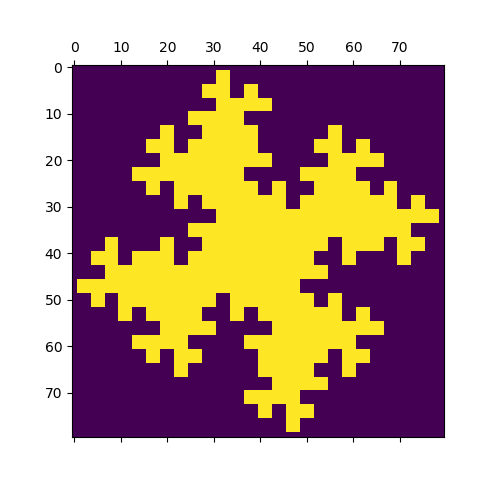

<IPython.core.display.Javascript object>


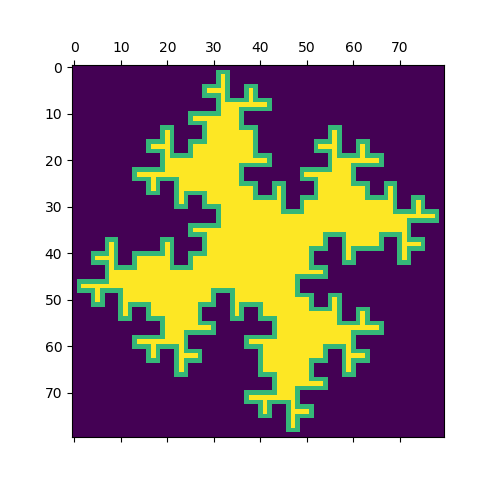

In [265]:
gridc, Pc, xlistc, ylistc = makeGrid(3, 2, 1)
statesc, coordsc = makeStates(Pc, xlistc, ylistc)
Nxc = len(statesc[0])
print(Nxc)
plt.matshow(statesc)
Uc = Ulist(xlistc, ylistc, statesc)
Nc = len(Uc)
ch = np.zeros([Nxc,Nxc])
i = 0
for a in Uc:
    ch[a[0],a[1]] = BC(Uc, statesc, Nc, i)
    i+= 1
        
plt.matshow(ch+statesc)
#plt.plot(27*Pc[0],27*Pc[1], 'w-', alpha=1, zorder = 3)

<IPython.core.display.Javascript object>


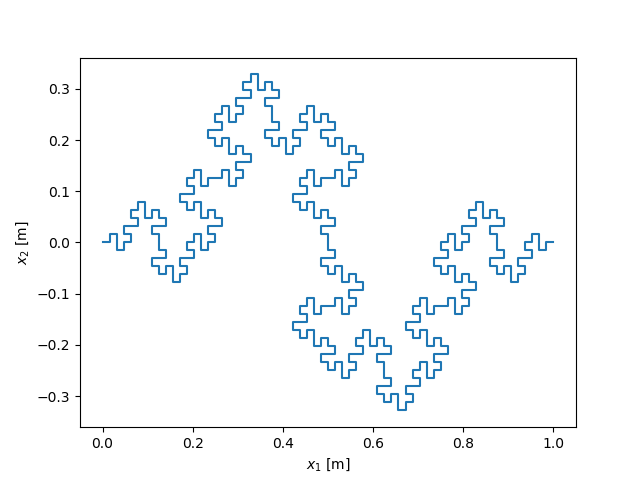

Text(0, 0.5, '$x_2$ [m]')

In [705]:
yay0 = fractalGenerator(1, 3)
yay1 = fractalCorners(1, 1)
yay2 = fractalCorners(1, 2)
yay3 = fractalCorners(1, 3)

plt.figure()

# plt.subplot(2,2,1)
# plt.plot(yay0[0], yay0[1])
# plt.subplot(2,2,2)
# plt.plot(yay1[0], yay1[1])
# plt.subplot(2,2,3)
# plt.plot(yay2[0], yay2[1])
# plt.subplot(2,2,4)
# plt.plot(yay3[0], yay3[1])

plt.plot(yay0[0], yay0[1])
plt.xlabel(r'$x_1$ [m]')
plt.ylabel(r'$x_2$ [m]')

<IPython.core.display.Javascript object>


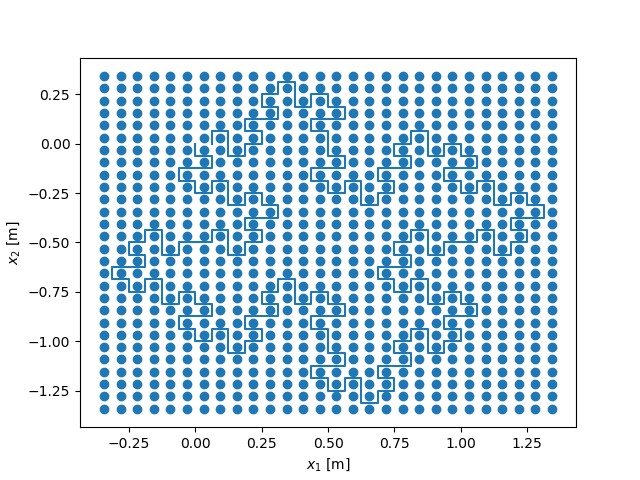

-8.573388203020338e-05


In [691]:
%matplotlib notebook
P1 = fractalCorners(1, 1)
P2 = fractalCorners(1, 2)
P3 = fractalCorners(1, 3)
P0 = fractalCorners(1, 0)

# vax, hax, lax, dax = plt.subplots(4, 2, figsize=(7, 3))
# vax.plot(P0[0], P0[1])
# hax.plot(P1[0], P1[1])
# lax.plot(P2[0], P2[1])
# dax.plot(P3[0], P3[1])

# dig, (lax, dax) = plt.subplots(1, 2, figsize=(7, 3))
# lax.plot(P2[0], P2[1])
# dax.plot(P3[0], P3[1])

S = 1
Res = 1
Koch = 2
delta = S/(4**Koch)


plt.figure(5)
grid, P, xlist, ylist = makeGrid(S, Koch, Res)
P = fractalCorners(1, 2)

print(xlist[1]-xlist[0] - delta)
plt.scatter(grid[0], grid[1])
plt.plot(P[0], P[1])
plt.xlabel(r'$x_1$ [m]')
plt.ylabel(r'$x_2$ [m]')
# fig.set_size_inches(5, 5)
plt.show()

In [70]:
def main(S, Res, Koch, n5, n9, Nc):
    grid, P, xlist, ylist = makeGrid(S, Koch, Res)
    delta = xlist[1]-xlist[0]
    states, coords = makeStates(P, xlist, ylist)
    Nx = len(states)
    U = Ulist(xlist, ylist, states)
    N = len(U)
    A = S**2
    print(S**2, N*(delta/Res)**2)
    Lap9 = laplace9(U, states)
    #Lap9 =  ClampedLaplace9(U, states)
    Lap5 = laplace5(U, states)
    values9, modes9 = eigs(Lap9, k = n9, which = "SM") #, v0 = [0.1]*N)
    ind = np.argsort(-values9)
    #print(ind)
    lambdas9 = -values9[ind]
    modes9 = modes9.T[ind].T
    #order9 = np.where(lambdas9 > 1e-6)
    #lambdas9 = lambdas9[[np.where(lambdas9 > 1e-9)][::-1]]
    #print(ind)
    #modes9 = modes9[order9[0]].T
     #[:,order9]
    values5, modes5 = 0, 0 #eigs(Lap5, k = n5, which = "SM", v0 = [0.01]*N)
    order5 = 0 #np.argsort(-1*values5)
    lambdas5 = 0 #values5[order5]
    modes5 = 0 #modes5[:,order5]
    #print((lambdas9/delta**4)**0.25)
    #if n5 >= 10 and n9 >= 10:
        #print("Omegas for 5 point precision:, \n \n", "np.sqrt(-1*lambdas5[:10]/delta**2)", "\n \n Omegas for 9 point precision: \n \n", np.sqrt(-1*lambdas9[:10]/delta**4))
    #regdim(lambdas9, A, delta)
    Nx = len(states)
    Nc = min(Nc, len(lambdas9))
    cont = np.zeros([Nc, Nx, Nx])
    for i in range(Nc):
        contour = np.zeros([Nx, Nx])
        for j in range(len(modes9)):
            contour[U[j][1]][U[j][0]] = modes9[j][i]#*BC(U, states, N, j)
        cont[i] = contour*1/delta**0.5
    X, Y = np.meshgrid(xlist, ylist)
    return lambdas9, modes9, lambdas5, modes5, X, Y, cont, P

[0.00175153+0.j 0.0097752 +0.j 0.0097752 +0.j 0.01092658+0.j
 0.01106339+0.j 0.01181179+0.j 0.01181179+0.j]


In [71]:
%matplotlib notebook
l9, v9, l5, v5, X, Y, cont, P = main(1, 2, 2, 1, 20, 20)

1 0.2498220323957441


C:\Users\Fredrik Knapskog\Documents\Anakonda3\lib\site-packages\ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


In [73]:
print(l9)

[-6.39248311e-15-1.77973545e-15j -6.39248311e-15+1.77973545e-15j
 -4.24192399e-15-0.00000000e+00j -3.98868492e-15-4.09826755e-15j
 -3.98868492e-15+4.09826755e-15j -1.71989701e-15-2.57217797e-15j
 -1.71989701e-15+2.57217797e-15j  2.11307615e-16-2.34884790e-15j
  2.11307615e-16+2.34884790e-15j  8.40039843e-16-8.13047413e-15j
  8.40039843e-16+8.13047413e-15j  1.89410120e-15-4.24854764e-15j
  1.89410120e-15+4.24854764e-15j  4.28446883e-15-4.66738690e-15j
  4.28446883e-15+4.66738690e-15j  4.86811858e-15-5.77647146e-15j
  4.86811858e-15+5.77647146e-15j  5.19625575e-15-2.17823036e-15j
  5.19625575e-15+2.17823036e-15j  6.12957953e-15-0.00000000e+00j]


In [676]:
def regdim(kopi, A, delta):
    lambdas = copy.copy(np.abs(kopi))/delta**4
    omegas, Nas = aN(lambdas[0]**0.25)
    deltaNs = deltaN(omegas, Nas, A)
    z = np.log(deltaNs)
    rotohm = omegas
    logohm = np.log(omegas)
    dim = np.vstack([logohm, np.ones(len(logohm))]).T
    alpha, beta = np.linalg.lstsq(dim, z, rcond=None)[0]
    regx = np.log(np.linspace(omegas[0], omegas[-1], 1000))
    regy = alpha*regx + beta
    print("d = ", alpha)
    dregx = np.linspace(omegas[0], omegas[-1], len(omegas))
    dregy = np.exp(beta)*dregx**(alpha)
    plt.figure()
    plt.scatter(np.log(rotohm), np.log(deltaNs))
    plt.xlabel("log(Omega)")
    plt.ylabel("log(deltaN)")
    plt.plot(regx, regy, 'r')
    plt.figure()
    plt.scatter(rotohm, deltaNs)
    plt.plot(dregx, dregy, 'r')
    plt.xlabel("ohmega",fontsize=18)
    plt.ylabel("deltaN",fontsize=18)
    plt.show()

<IPython.core.display.Javascript object>


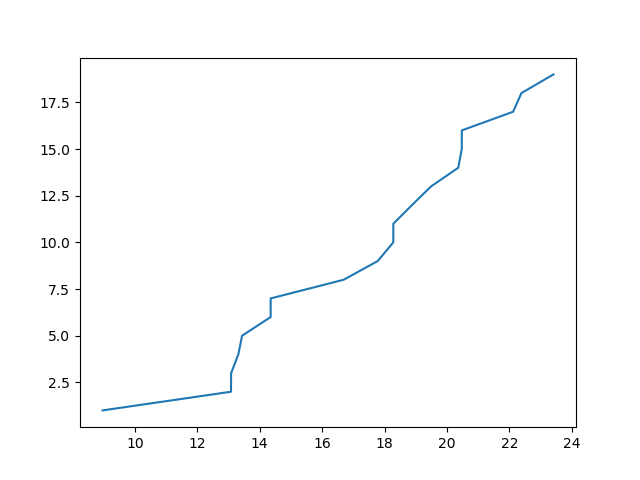

d =  1.498815680064227


<IPython.core.display.Javascript object>


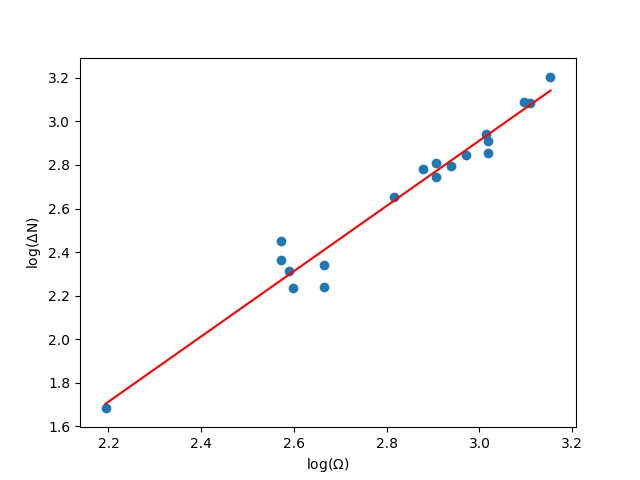

<IPython.core.display.Javascript object>


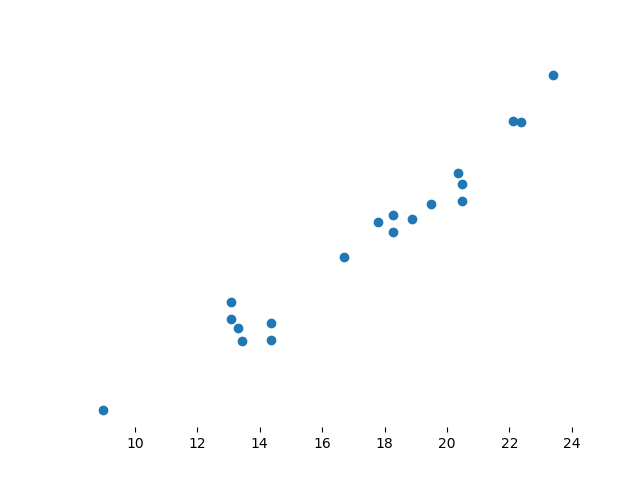

In [69]:
delta = X[0][0]-X[0][1]
regdim(l9, 1, delta)
#print(len(l9[0]))

20


<IPython.core.display.Javascript object>


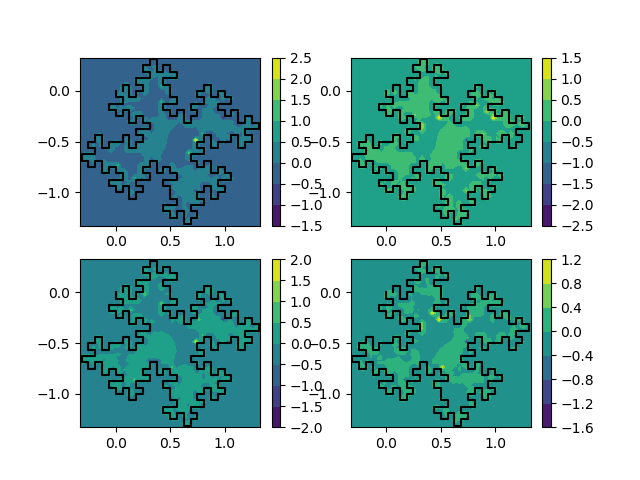

20


In [72]:
%matplotlib notebook
print(len(cont))
F =0
plt.figure()
plt.subplot(2,2,1)
plt.contourf(X, Y, -cont[F])
plt.plot(P[0],P[1], 'k-', alpha=1, zorder = 3)
plt.colorbar()
plt.subplot(2,2,2)
plt.contourf(X, Y, cont[F+1])
plt.plot(P[0],P[1], 'k-', alpha=1, zorder = 3)
plt.colorbar()
plt.subplot(2,2,3)
plt.contourf(X, Y, cont[F+2])
plt.plot(P[0],P[1], 'k-', alpha=1, zorder = 3)
plt.colorbar()
plt.subplot(2,2,4)
plt.contourf(X, Y, cont[F+3])
plt.plot(P[0],P[1], 'k-', alpha=1, zorder = 3)
plt.colorbar()
print(len(cont))

<IPython.core.display.Javascript object>


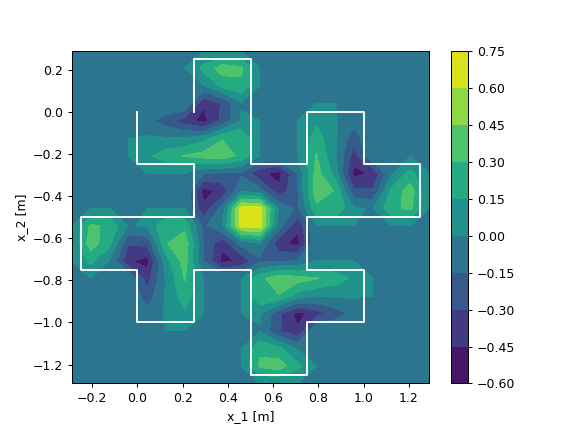

In [12]:
%matplotlib notebook
#print(l9[0]/delta**2)
plt.figure()
plt.xlabel("x_1 [m]")
plt.ylabel("x_2 [m]")
plt.contourf(X, Y, -cont[1])
plt.plot(P[0],P[1], 'w-', alpha=1, zorder = 3)
plt.colorbar()